In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM

from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"


In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [ ]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

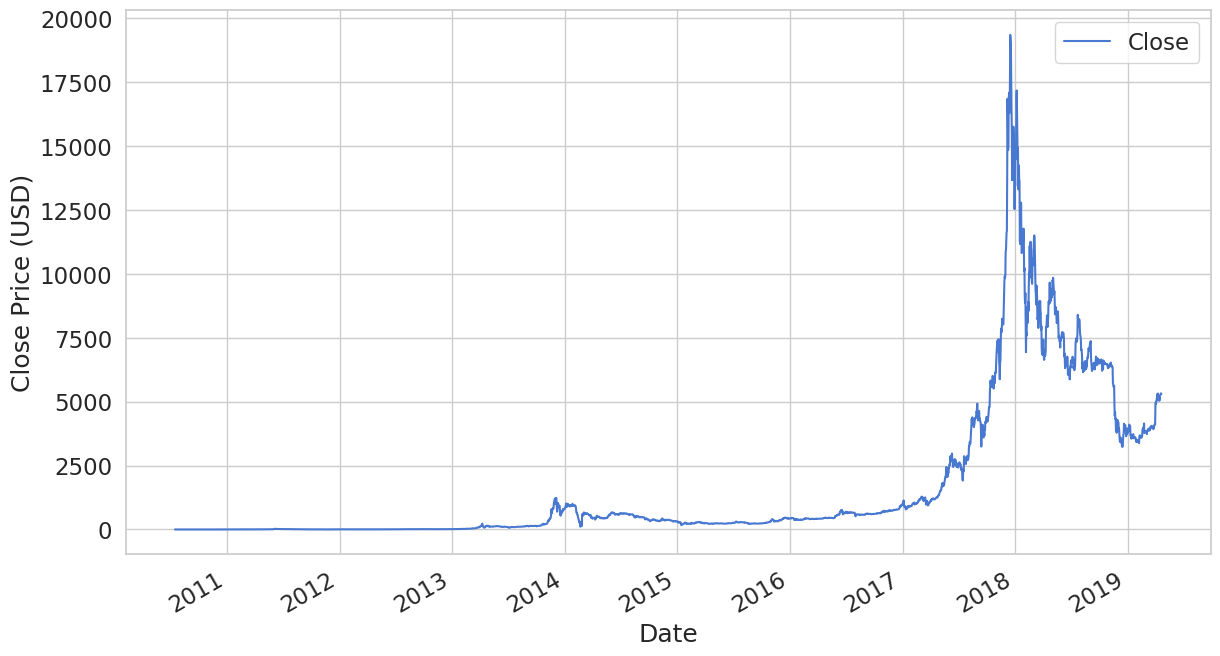

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [ ]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close

array([[0.00000000e+00],
       [1.87796187e-06],
       [1.61743537e-06],
       ...,
       [2.73732729e-01],
       [2.75317101e-01],
       [2.74260525e-01]])

In [ ]:
scaled_close.shape

(3201, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
scaled_close

array([[0.00000000e+00],
       [1.87796187e-06],
       [1.61743537e-06],
       ...,
       [2.73732729e-01],
       [2.75317101e-01],
       [2.74260525e-01]])

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape

(2945, 99, 1)

In [ ]:
X_test.shape

(156, 99, 1)

# Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [ ]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=260,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/260
42/42 [==============================] - 17s 89ms/step - loss: 0.0021 - val_loss: 0.0071
Epoch 2/260
42/42 [==============================] - 2s 38ms/step - loss: 0.0111 - val_loss: 0.0134
Epoch 3/260
42/42 [==============================] - 2s 37ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 4/260
42/42 [==============================] - 2s 37ms/step - loss: 0.0176 - val_loss: 0.0436
Epoch 5/260
42/42 [==============================] - 2s 43ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/260
42/42 [==============================] - 2s 41ms/step - loss: 0.0141 - val_loss: 0.0621
Epoch 7/260
42/42 [==============================] - 2s 37ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 8/260
42/42 [==============================] - 2s 37ms/step - loss: 0.0096 - val_loss: 0.0168
Epoch 9/260
42/42 [==============================] - 2s 38ms/step - loss: 0.0130 - val_loss: 0.0725
Epoch 10/260
42/42 [==============================] - 2s 37ms/step - loss: 0.0140 - val_loss: 0.064

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 26ms/step - loss: 8.5726e-04


0.0008572640945203602

In [ ]:
model.save("project.keras")

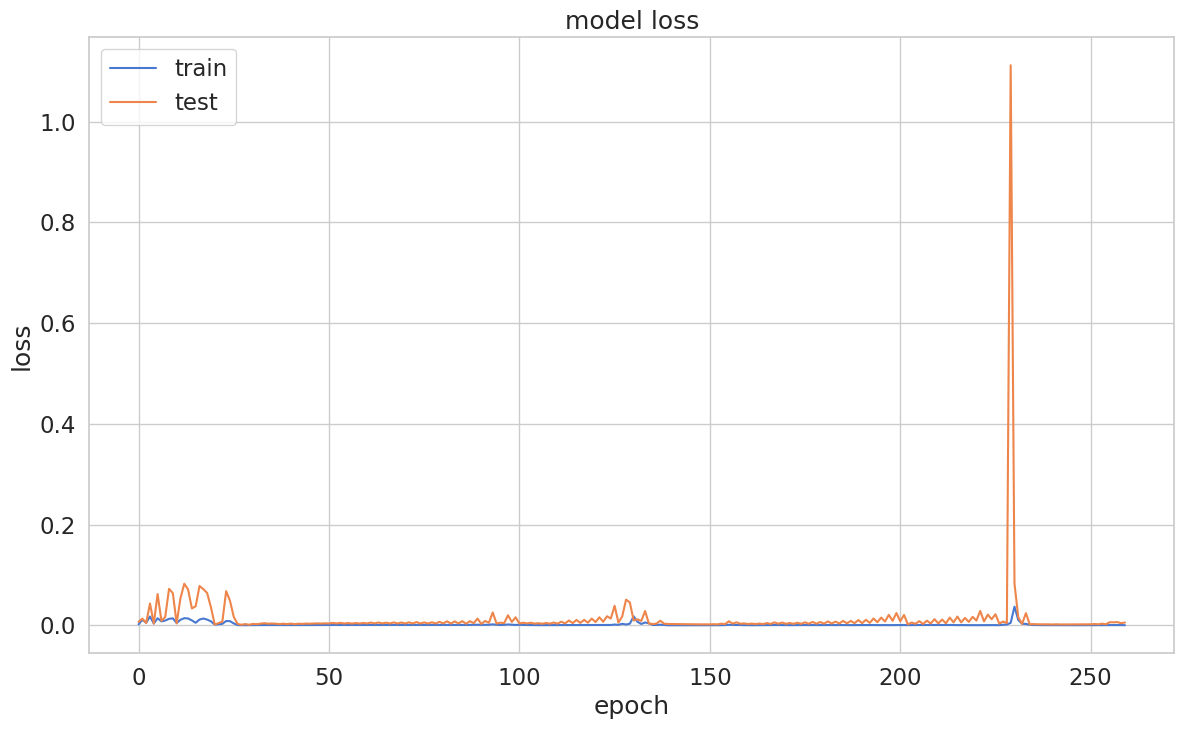

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

5/5 [==============================] - 4s 20ms/step


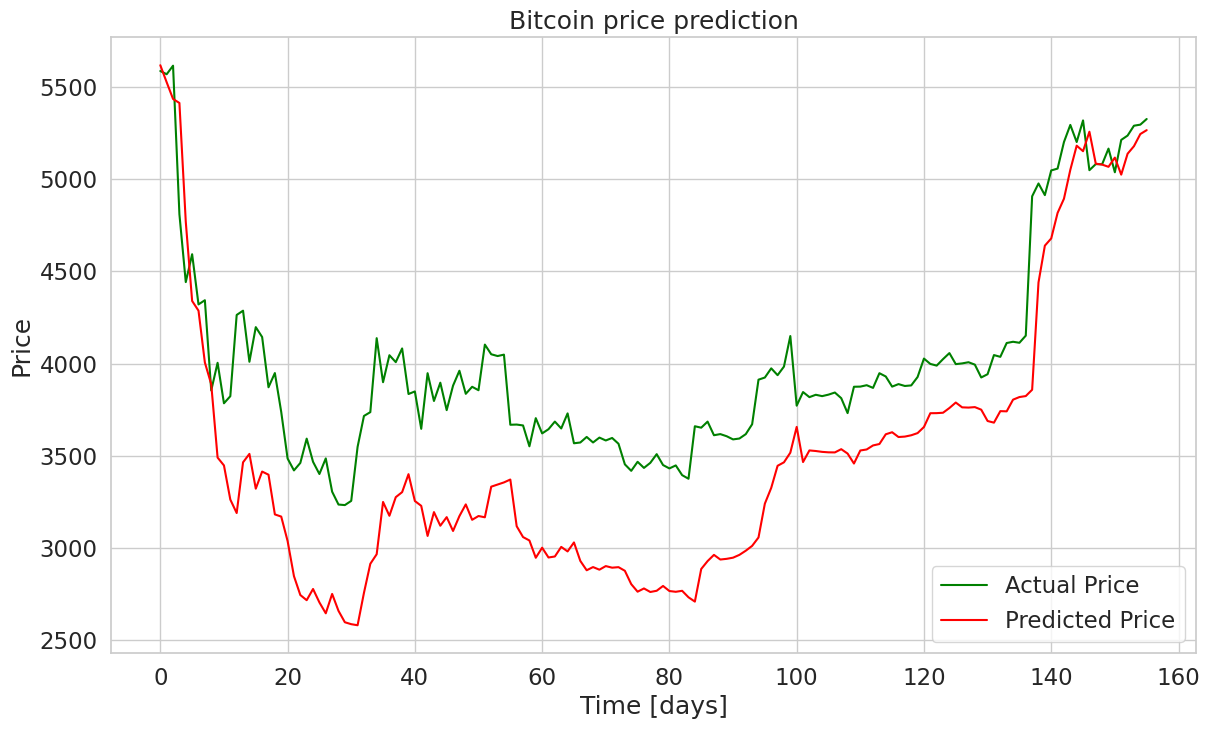

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_test_inverse and y_hat_inverse are numpy arrays or can be converted to numpy arrays
y_test_inverse = np.array(y_test_inverse)
y_hat_inverse = np.array(y_hat_inverse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, y_hat_inverse)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverse, y_hat_inverse)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared (R²)
r2 = r2_score(y_test_inverse, y_hat_inverse)
print(f"R-squared (R²): {r2}")
from sklearn.metrics import mean_absolute_percentage_error

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test_inverse, y_hat_inverse)
accuracy = 100 - (mape * 100)
print(f"Accuracy: {accuracy}%")

Mean Absolute Error (MAE): 504.98667710136226
Mean Squared Error (MSE): 320827.6330260433
Root Mean Squared Error (RMSE): 566.4164837167465
R-squared (R²): -0.05444467548351484
Accuracy: 86.76566241738341%
